# Notebook for clustering on HPC data gathered from CFD folders
## This notebook takes data generated by the module runcrawler and tries to find clusters in the runs to be able to sort runs, see if they converge or crash due to the same reasons (for example a code version).

In [41]:
import json
from pandas.io.json import json_normalize
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [42]:
sns.set(font_scale=1.5)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

Here we create a dataframe from all the json files gathered by runcrawler.py in the DATABASE folder.

In [43]:
df = pd.DataFrame()
for filename in glob.glob('./DATABASE/*.json'):
    with open(filename) as json_file:
        data = json.load(json_file)
        new = json_normalize(data['log_monitoring'][0]['contents'])
        new['User_name'] = filename.split('__')[3]
        df= pd.concat([df, new])

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


We add an index for each run. So when we visualize the head of the dataframe (i.e. the 5 first lines, 
we see each line is a run, each column is a run feature.)

In [44]:
ind = np.arange(0, len(df), 1)
ind = pd.Series(ind)
df['index_run'] = ind.values
df = df.set_index('index_run')
df.head()

User_name        creation_time                   err_log params.CFL  \
index_run                                                                       
0             dupuy  2019-06-24T02:03:28  [before wrap up\n ok, 0]   70000000   
1            potier  2019-02-26T11:55:11  [before wrap up\n ok, 0]   70000000   
2             rossi  2019-04-24T13:26:27  [before wrap up\n ok, 0]   00000000   
3           gullaud  2020-07-31T09:40:10  [before wrap up\n ok, 0]   70000000   
4            potier  2019-05-15T14:01:25  [before wrap up\n ok, 0]   70000000   

          params.LES_model params.artificial_viscosity_model  \
index_run                                                      
0                    sigma                             colin   
1                       no                                no   
2                     wale                     Colin_species   
3                     wale                     colin_species   
4                       no                           jameson   

          params.convection_scheme   params.mixture_name params.ncell_group  \
index_run                                                                     
0                             TTGC            KERO_LUCHE                100   
1                               LW                   AIR                100   
2                             TTGC            KERO_LUCHE                100   
3                             TTGC                  C3H8                 60   
4                               LW  N2_qpf_poiseuille_2D                 40   

          params.partitioner  ...  vars.dimension  vars.elapsed_time  \
index_run                     ...                                      
0                   parmetis  ...             3.0           41677.42   
1                   parmetis  ...             2.0              16.12   
2                   parmetis  ...             3.0           41567.26   
3                   parmetis  ...             3.0             157.55   
4                   parmetis  ...             2.0              17.93   

          vars.final_iteration vars.initial_iteration  vars.initial_time  \
index_run                                                                  
0                    2084205.0              2054791.0           0.085092   
1                       7854.0                    0.0           0.000000   
2                          NaN              2993062.0           0.177500   
3                        100.0                    0.0           0.000000   
4                      17565.0                    0.0           0.000000   

          vars.mesh_cells  vars.nodes  vars.number_of_probes  \
index_run                                                      
0              45486233.0   8064050.0                  122.0   
1                 48450.0     24576.0                    NaN   
2              45469910.0   8043365.0                    3.0   
3              19616196.0   3452844.0                   72.0   
4                   400.0       441.0                    2.0   

           vars.physical_time  vars.time_per_ite  
index_run                                         
0                    0.086242             1.4165  
1                    0.120003             0.0020  
2                         NaN             0.3364  
3                    0.000011             1.5336  
4                    0.000311             0.0009  

[5 rows x 28 columns]

Here is the list of all features: 
- the ones starting with params come from the run.params file
- the ones starting with vars were gathered from the log file coming out from AVBP.

In [45]:
df.columns

Index(['User_name', 'creation_time', 'err_log', 'params.CFL',
       'params.LES_model', 'params.artificial_viscosity_model',
       'params.convection_scheme', 'params.mixture_name', 'params.ncell_group',
       'params.partitioner', 'params.reactive_flow', 'params.real_gas',
       'params.smu2', 'params.solver_type', 'params.two_phase_flow',
       'vars.AVBP_version', 'vars.CPU_time_s', 'vars.MPI_processes',
       'vars.dimension', 'vars.elapsed_time', 'vars.final_iteration',
       'vars.initial_iteration', 'vars.initial_time', 'vars.mesh_cells',
       'vars.nodes', 'vars.number_of_probes', 'vars.physical_time',
       'vars.time_per_ite'],
      dtype='object')

In [46]:
print('The dataframe contains', len(df), 'runs and contains',  len(df.columns), 'features or run parameters')

The dataframe contains 217 runs and contains 28 features or run parameters


## Data cleaning: 
- some filling of NaN values

First, we are going to print how much NaN values we have and fill them or handle them the best we can,
for example we see that the parameter 'smu2' has 1484 NaN values, so if we drop all runs that are in this case, we are going to drop half the database!! But if 'smu2' is NaN, we can replace it by 0, because if it's a Nan, it is just that it has not
been found in the run.params file, but it's normal, it's probably because it was with a run that didn't have any smu2 
parameter specified.

In [47]:
df.isnull().sum()

User_name                              0
creation_time                          0
err_log                                0
params.CFL                             0
params.LES_model                       0
params.artificial_viscosity_model      0
params.convection_scheme               0
params.mixture_name                    0
params.ncell_group                     8
params.partitioner                     9
params.reactive_flow                   0
params.real_gas                      109
params.smu2                            3
params.solver_type                     0
params.two_phase_flow                151
vars.AVBP_version                     24
vars.CPU_time_s                       36
vars.MPI_processes                    29
vars.dimension                         5
vars.elapsed_time                     28
vars.final_iteration                  34
vars.initial_iteration                 7
vars.initial_time                      7
vars.mesh_cells                        6
vars.nodes      

In [48]:
# Anonymisation des user names
dict = { 'gullaud': 'User 1', 'rossi': 'User 2', 
        'pouech': 'User 3', 'dupuy': 'User 4', 'potier': 'User 5' }

df['User_name'] = df['User_name'].map(dict)

In [50]:
# un run qui a Nan en nb of probes est un run qui n'a pas de probes
df['vars.number_of_probes'] = df['vars.number_of_probes'].fillna(0.0)
df['params.real_gas'] = df['params.real_gas'].fillna(0.0)
# un run qui n'a pas tourné a 0 en CPU_time ...
df['vars.CPU_time_s'] = df['vars.CPU_time_s'].fillna(0.0)
df['params.two_phase_flow'] = df['params.two_phase_flow'].fillna(0.0)
df['vars.physical_time'] = df['vars.physical_time'].fillna(0.0)
df['vars.elapsed_time'] = df['vars.elapsed_time'].fillna(0.0)
df['vars.final_iteration'] = df['vars.final_iteration'].fillna(0.0)
df['vars.initial_time'] = df['vars.initial_time'].fillna(0.0)
df['params.smu2'] = df['params.smu2'].fillna(0.0)
df['vars.time_per_ite'] = df['vars.time_per_ite'].fillna(0.0)

If LES is no, we replace it by DNS (Direct Numerical Simulation) for better understanding:

In [51]:
# si LES = no alors on remplace par DNS.
df['params.LES_model'] = df['params.LES_model'].apply(lambda x: 'DNS' if x=='no' else x )

There seems to be a case sensitive issue in AVBP with the "colin_species" artificial viscosity model. But we don't want 
it to be understood as if it was two different models.

In [52]:
# traitement de la redondance Colin_species vs colin_species
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'no visc model' if x =='no' else x)
df['params.artificial_viscosity_model'] = df['params.artificial_viscosity_model'].apply(lambda x: 'colin_species' if x == 'Colin_species' else x)

In [53]:
df['params.solver_type'] = df['params.solver_type'].apply(lambda x: 'ns' if (x =='NS' or x =='Ns') else x)

In [54]:
df = df.dropna(subset=['vars.nodes'])

In [55]:
df = df.dropna(subset=['vars.time_per_ite'])
df = df.dropna(subset=['vars.MPI_processes'])
df = df.dropna(subset=['params.ncell_group'])

Some parameters are understood as strings so we have to convert them to integers or floats.

In [56]:
df['vars.nodes'] = df['vars.nodes'].apply(lambda x: int(x))
df['vars.dimension'] = df['vars.dimension'].apply(lambda x: int(x))
df['vars.MPI_processes'] = df['vars.MPI_processes'].apply(lambda x: int(x))
df['params.ncell_group'] = df['params.ncell_group'].apply(lambda x: int(x))
df['params.smu2'] = df['params.smu2'].apply(lambda x: float(x))

Let's just check we don't have any more NaN in our data:

In [57]:
df.isnull().sum()

User_name                            0
creation_time                        0
err_log                              0
params.CFL                           0
params.LES_model                     0
params.artificial_viscosity_model    0
params.convection_scheme             0
params.mixture_name                  0
params.ncell_group                   0
params.partitioner                   1
params.reactive_flow                 0
params.real_gas                      0
params.smu2                          0
params.solver_type                   0
params.two_phase_flow                0
vars.AVBP_version                    0
vars.CPU_time_s                      0
vars.MPI_processes                   0
vars.dimension                       0
vars.elapsed_time                    0
vars.final_iteration                 0
vars.initial_iteration               1
vars.initial_time                    0
vars.mesh_cells                      0
vars.nodes                           0
vars.number_of_probes    

We drop the remaining NaN values

In [58]:
df = df.dropna()

In [59]:
df.isnull().sum()

User_name                            0
creation_time                        0
err_log                              0
params.CFL                           0
params.LES_model                     0
params.artificial_viscosity_model    0
params.convection_scheme             0
params.mixture_name                  0
params.ncell_group                   0
params.partitioner                   0
params.reactive_flow                 0
params.real_gas                      0
params.smu2                          0
params.solver_type                   0
params.two_phase_flow                0
vars.AVBP_version                    0
vars.CPU_time_s                      0
vars.MPI_processes                   0
vars.dimension                       0
vars.elapsed_time                    0
vars.final_iteration                 0
vars.initial_iteration               0
vars.initial_time                    0
vars.mesh_cells                      0
vars.nodes                           0
vars.number_of_probes    

## Data separation into 2 dataframes, one from setup, the other one from run log.

We split the dataframe into two dataframes, one of run setup, which can be the parameters read in run.params, and one read in avbp.o giving the HPC parameters.

In [60]:
run_setup = ['params.LES_model',
       'params.artificial_viscosity_model', 'params.convection_scheme',
       'params.mixture_name',
       'params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.solver_type', 'params.two_phase_flow', 'vars.AVBP_version', 'vars.dimension', 
       'vars.mesh_cells', 'vars.number_of_probes']

In [61]:
run_result = ['creation_time', 'err_log','vars.CPU_time_s', 'vars.elapsed_time', 
              'vars.final_iteration', 'vars.initial_iteration',
               'vars.initial_time', 'vars.physical_time', 'vars.time_per_ite' ,
               'params.ncell_group', 'params.partitioner', 'vars.MPI_processes', 'User_name']

In [62]:
df_setup = df[run_setup]

In [63]:
df_log = df[run_result]

In [64]:
df_setup.head()

params.LES_model params.artificial_viscosity_model  \
index_run                                                      
0                    sigma                             colin   
1                      DNS                     no visc model   
2                     wale                     colin_species   
3                     wale                     colin_species   
5                    sigma                        colin_rhou   

          params.convection_scheme params.mixture_name  params.reactive_flow  \
index_run                                                                      
0                             TTGC          KERO_LUCHE                     1   
1                               LW                 AIR                     0   
2                             TTGC          KERO_LUCHE                     1   
3                             TTGC                C3H8                     1   
5                               LW                 AIR                     0   

           params.real_gas  params.smu2 params.solver_type  \
index_run                                                    
0                      0.0          1.0                 ns   
1                      0.0          0.0                 ns   
2                      0.0          1.0                 ns   
3                      0.0          0.0                 ns   
5                      0.0          0.0                 ns   

           params.two_phase_flow vars.AVBP_version  vars.dimension  \
index_run                                                            
0                            0.0             7.3.0               3   
1                            0.0             7.3.0               2   
2                            0.0             7.3.0               3   
3                            0.0             7.6.0               3   
5                            0.0             7.3.0               3   

           vars.mesh_cells  vars.number_of_probes  
index_run                                          
0               45486233.0                  122.0  
1                  48450.0                    0.0  
2               45469910.0                    3.0  
3               19616196.0                   72.0  
5                  47491.0                    1.0

In [65]:
df_log.head()

creation_time                   err_log  vars.CPU_time_s  \
index_run                                                                   
0          2019-06-24T02:03:28  [before wrap up\n ok, 0]       15000000.0   
1          2019-02-26T11:55:11  [before wrap up\n ok, 0]            386.8   
2          2019-04-24T13:26:27  [before wrap up\n ok, 0]       46560000.0   
3          2020-07-31T09:40:10  [before wrap up\n ok, 0]          85080.0   
5          2019-12-12T18:33:59  [before run params, 110]            654.9   

           vars.elapsed_time  vars.final_iteration  vars.initial_iteration  \
index_run                                                                    
0                   41677.42             2084205.0               2054791.0   
1                      16.12                7854.0                     0.0   
2                   41567.26                   0.0               2993062.0   
3                     157.55                 100.0                     0.0   
5                     327.47                5039.0                     0.0   

           vars.initial_time  vars.physical_time  vars.time_per_ite  \
index_run                                                             
0                   0.085092            0.086242             1.4165   
1                   0.000000            0.120003             0.0020   
2                   0.177500            0.000000             0.3364   
3                   0.000000            0.000011             1.5336   
5                   0.000000            0.002761             0.0648   

           params.ncell_group params.partitioner  vars.MPI_processes User_name  
index_run                                                                       
0                         100           parmetis                 360    User 4  
1                         100           parmetis                  24    User 5  
2                         100           parmetis                1120    User 2  
3                          60           parmetis                 540    User 1  
5                         100           parmetis                   2    User 5

# Number of runs depending of the dimension

In [66]:
df_3D = df[df['vars.dimension'] == 3]
df_2D = df[df['vars.dimension'] == 2]
df_3D['eff'] = df_3D['vars.time_per_ite']*1000000/df_3D['vars.nodes']
df_2D['eff'] = df_2D['vars.time_per_ite']*1000000/df_2D['vars.nodes']

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


# Work on error log

We add a column with the error code (to be continued), if the error code is 0, it means that the run is converged.
so we create a column 'CONVERGED' which can take the value 0 or 1.

In [67]:
df['error_code'] = df['err_log'].apply(lambda x: str(x).split(',')[-1][:-1])

In [68]:
df['error_code']

index_run
0         0
1         0
2         0
3         0
5       110
6         0
7         0
8         0
10        0
11        0
13        0
14        0
15        0
16        0
17      290
20        0
21        0
22        0
24        0
25        0
26        0
27        0
28      110
29        0
30        0
31        0
32        0
33        0
36        0
38        0
       ... 
180       0
181       0
182       0
183       0
184       0
186       0
187       0
188       0
189       0
190     110
191       0
192     290
194       0
195       0
196       0
197       0
199       0
200     110
201     290
202       0
203       0
204       0
205     110
206       0
208       0
210     290
213       0
214     110
215       0
216       0
Name: error_code, Length: 176, dtype: object

In [69]:
def conversion(x):
    if x ==' 0':
        return 1
    else:
        return 0

In [70]:
df['converged'] = df['error_code'].apply(conversion)

In [71]:
df['converged']

index_run
0      1
1      1
2      1
3      1
5      0
6      1
7      1
8      1
10     1
11     1
13     1
14     1
15     1
16     1
17     0
20     1
21     1
22     1
24     1
25     1
26     1
27     1
28     0
29     1
30     1
31     1
32     1
33     1
36     1
38     1
      ..
180    1
181    1
182    1
183    1
184    1
186    1
187    1
188    1
189    1
190    0
191    1
192    0
194    1
195    1
196    1
197    1
199    1
200    0
201    0
202    1
203    1
204    1
205    0
206    1
208    1
210    0
213    1
214    0
215    1
216    1
Name: converged, Length: 176, dtype: int64

In [72]:
df[df['converged']==0]

User_name        creation_time  \
index_run                                  
5            User 5  2019-12-12T18:33:59   
17           User 2  2019-08-07T09:51:56   
28           User 4  2019-02-26T20:28:31   
44           User 5  2019-09-03T14:26:53   
46           User 2  2019-08-07T11:37:06   
52           User 3  2020-07-05T18:35:11   
58           User 2  2020-03-16T11:56:30   
60           User 1  2019-07-31T12:46:53   
69           User 1  2020-04-14T10:47:46   
71           User 1  2020-07-13T09:21:17   
78           User 1  2019-12-11T10:13:06   
80           User 5  2019-05-15T14:01:26   
82           User 3  2020-04-02T06:56:18   
86           User 1  2020-04-04T16:17:06   
91           User 5  2019-07-24T09:22:38   
93           User 5  2019-08-23T12:39:37   
97           User 5  2019-09-07T08:36:19   
98           User 3  2019-01-16T19:26:37   
100          User 3  2020-07-13T19:36:29   
104          User 5  2019-08-26T13:51:32   
106          User 3  2020-07-15T20:23:26   
111          User 4  2018-12-16T03:25:27   
115          User 3  2020-07-13T14:33:58   
122          User 5  2019-07-11T15:05:04   
127          User 2  2019-03-13T09:33:51   
129          User 4  2018-08-22T12:45:47   
131          User 1  2020-04-17T14:58:02   
134          User 5  2019-07-11T15:04:58   
136          User 5  2019-07-11T15:05:10   
140          User 3  2020-04-22T05:26:55   
147          User 5  2019-05-15T14:01:26   
152          User 4  2019-02-28T21:40:19   
155          User 4  2019-02-02T07:36:20   
156          User 4  2018-10-02T23:48:33   
163          User 5  2019-05-15T14:01:26   
166          User 5  2019-07-11T15:05:15   
167          User 5  2019-07-24T09:22:38   
170          User 2  2018-10-16T16:31:29   
172          User 1  2020-06-18T23:54:02   
173          User 1  2019-12-10T18:09:38   
178          User 2  2019-03-13T10:25:50   
190          User 5  2019-12-12T18:34:04   
192          User 4  2018-08-30T16:14:29   
200          User 5  2019-12-12T18:34:00   
201          User 2  2019-08-07T09:22:46   
205          User 5  2019-07-11T15:05:11   
210          User 1  2020-04-07T23:25:44   
214          User 4  2019-10-03T08:35:24   

                                               err_log params.CFL  \
index_run                                                           
5                             [before run params, 110]   70000000   
17         [wall dist ok,\n before other preproc, 290]   00000000   
28                            [before run params, 110]   70000000   
44                            [before run params, 110]   70000000   
46         [wall dist ok,\n before other preproc, 290]   00000000   
52                            [before run params, 110]   70000000   
58                            [before run params, 110]   00000000   
60         [wall dist ok,\n before other preproc, 290]   70000000   
69                            [before run params, 110]   70000000   
71                            [before run params, 110]   70000000   
78         [wall dist ok,\n before other preproc, 290]   70000000   
80                            [before run params, 110]   70000000   
82                            [before run params, 110]   70000000   
86                            [before run params, 110]   70000000   
91                            [before run params, 110]   70000000   
93                            [before run params, 110]   70000000   
97                            [before run params, 110]   70000000   
98                            [before run params, 110]   70000000   
100                           [before run params, 110]   70000000   
104                           [before run params, 110]   70000000   
106                           [before run params, 110]   70000000   
111                           [before run params, 110]   70000000   
115                           [before run params, 110]   70000000   
122                           [before run params, 110]   70000000   
127        [wal

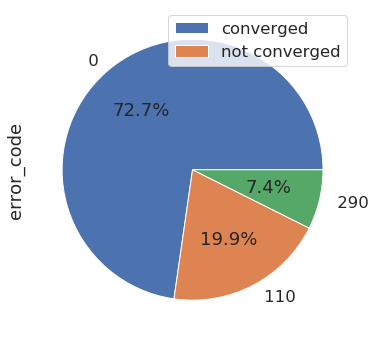

In [73]:
fig = plt.figure(figsize = (10,6))
df['error_code'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
state=['converged', 'not converged']
plt.legend(['converged', 'not converged'])
#plt.legend(loc = 1)

## PCA on setup

We start by performing a Principal Component Analysis (PCA) to reduce dimension. Remember we have 26 features describing
the runs, we want to be able to represent them in 2D for example.

To start with, we are going to use only the dataframe from the setup, so mainly using data that come from the run.params, physical parameters describing the run even if we might use some data from the log such as the code version.

We start by working on the data by 
- removing remaining NaN if any, 
- drop some features that have 0 standard deviation,
- convert strings into numerical data,
- perform one-hot-encoding on categorical data.

Now we import packages from scikit-learn to use the well-known PCA model.

In [74]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [75]:
df_setup.columns

Index(['params.LES_model', 'params.artificial_viscosity_model',
       'params.convection_scheme', 'params.mixture_name',
       'params.reactive_flow', 'params.real_gas', 'params.smu2',
       'params.solver_type', 'params.two_phase_flow', 'vars.AVBP_version',
       'vars.dimension', 'vars.mesh_cells', 'vars.number_of_probes'],
      dtype='object')

We create a dataframe for PCA, which we call df_pca and another dataframe, containing also the info of whether the
run converged or not.

In [76]:
df_pca = df_log
df_pca_c = pd.concat([df_log, df['converged']], axis = 1)
df_pca = df_pca_c

In [77]:
df_pca.head()

creation_time                   err_log  vars.CPU_time_s  \
index_run                                                                   
0          2019-06-24T02:03:28  [before wrap up\n ok, 0]       15000000.0   
1          2019-02-26T11:55:11  [before wrap up\n ok, 0]            386.8   
2          2019-04-24T13:26:27  [before wrap up\n ok, 0]       46560000.0   
3          2020-07-31T09:40:10  [before wrap up\n ok, 0]          85080.0   
5          2019-12-12T18:33:59  [before run params, 110]            654.9   

           vars.elapsed_time  vars.final_iteration  vars.initial_iteration  \
index_run                                                                    
0                   41677.42             2084205.0               2054791.0   
1                      16.12                7854.0                     0.0   
2                   41567.26                   0.0               2993062.0   
3                     157.55                 100.0                     0.0   
5                     327.47                5039.0                     0.0   

           vars.initial_time  vars.physical_time  vars.time_per_ite  \
index_run                                                             
0                   0.085092            0.086242             1.4165   
1                   0.000000            0.120003             0.0020   
2                   0.177500            0.000000             0.3364   
3                   0.000000            0.000011             1.5336   
5                   0.000000            0.002761             0.0648   

           params.ncell_group params.partitioner  vars.MPI_processes  \
index_run                                                              
0                         100           parmetis                 360   
1                         100           parmetis                  24   
2                         100           parmetis                1120   
3                          60           parmetis                 540   
5                         100           parmetis                   2   

          User_name  converged  
index_run                       
0            User 4          1  
1            User 5          1  
2            User 2          1  
3            User 1          1  
5            User 5          0

One-hot encoding of categorical data

In [78]:
dummies_partitioner = pd.get_dummies(df_pca['params.partitioner'])
df_pca = pd.concat([df_pca.drop('params.partitioner', axis = 1), dummies_partitioner], axis=1)


In [79]:
#User_name
dummies_username = pd.get_dummies(df_pca['User_name'])
df_pca = pd.concat([df_pca.drop('User_name', axis = 1), dummies_username], axis=1)

Transformation de la date

In [80]:
df_pca['creation_time'] = df_pca['creation_time'].apply(lambda x : pd.to_datetime(x))

In [81]:
df_pca['date_hour'] = df_pca['creation_time'].apply(lambda x: x.hour)
df_pca['date_hour']
df_pca['date_year'] = df_pca['creation_time'].apply(lambda x: x.year)
df_pca['date_year']
df_pca['date_year'] = df_pca['creation_time'].apply(lambda x: x.year)
df_pca['date_year']
df_pca['dayofweek'] = df_pca['creation_time'].apply(lambda x: x.dayofweek)


In [82]:
df_pca = df_pca.drop('creation_time', axis = 1)

In [83]:
dict_week = {0: 'Monday', 1: 'Tuesday', 2: 'Wednedsday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

In [84]:
df_pca['dayofweek'] = df_pca['dayofweek'].map(dict_week)

In [85]:
dummies_dayofweek = pd.get_dummies(df_pca['dayofweek'])
dummies_dayofweek
df_pca = pd.concat([df_pca.drop('dayofweek', axis = 1), dummies_dayofweek], axis =1)

In [86]:
df_pca = df_pca.dropna()

In [87]:
df_pca_c = df_pca
df_pca = df_pca.drop('converged', axis = 1)

In [88]:
df_pca = df_pca.drop('err_log', axis =1)

In [89]:
print(len(df_pca_c))

176


In [90]:
print("We have a dataframe that contains", len(df_pca_c), "runs and", len(df_pca.columns), "features \
     that we want to boil down to 2 with the PCA: ")

We have a dataframe that contains 176 runs and 24 features      that we want to boil down to 2 with the PCA: 


In [91]:
df_pca.columns

Index(['vars.CPU_time_s', 'vars.elapsed_time', 'vars.final_iteration',
       'vars.initial_iteration', 'vars.initial_time', 'vars.physical_time',
       'vars.time_per_ite', 'params.ncell_group', 'vars.MPI_processes',
       'parmetis', 'User 1', 'User 2', 'User 3', 'User 4', 'User 5',
       'date_hour', 'date_year', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednedsday'],
      dtype='object')

In [92]:
print(len(df_pca), len(df_pca_c))

176 176


In [93]:
df_pca.head()

vars.CPU_time_s  vars.elapsed_time  vars.final_iteration  \
index_run                                                             
0               15000000.0           41677.42             2084205.0   
1                    386.8              16.12                7854.0   
2               46560000.0           41567.26                   0.0   
3                  85080.0             157.55                 100.0   
5                    654.9             327.47                5039.0   

           vars.initial_iteration  vars.initial_time  vars.physical_time  \
index_run                                                                  
0                       2054791.0           0.085092            0.086242   
1                             0.0           0.000000            0.120003   
2                       2993062.0           0.177500            0.000000   
3                             0.0           0.000000            0.000011   
5                             0.0           0.000000            0.002761   

           vars.time_per_ite  params.ncell_group  vars.MPI_processes  \
index_run                                                              
0                     1.4165                 100                 360   
1                     0.0020                 100                  24   
2                     0.3364                 100                1120   
3                     1.5336                  60                 540   
5                     0.0648                 100                   2   

           parmetis  ...  User 5  date_hour  date_year  Friday  Monday  \
index_run            ...                                                 
0                 1  ...       0          2       2019       0       1   
1                 1  ...       1         11       2019       0       0   
2                 1  ...       0         13       2019       0       0   
3                 1  ...       0          9       2020       1       0   
5                 1  ...       1         18       2019       0       0   

           Saturday  Sunday  Thursday  Tuesday  Wednedsday  
index_run                                                   
0                 0       0         0        0           0  
1                 0       0         0        1           0  
2                 0       0         0        0           1  
3                 0       0         0        0           0  
5                 0       0         1        0           0  

[5 rows x 24 columns]

Now we have a dataframe containing only numerical values, with no null values.

In [94]:
#we create an instance of PCA: we want to determine how many PCA components
#allow to keep 80 % of the standard deviation of the data
pca = PCA(n_components = 7)
# standardScaler, for each variable, withdraws the mean value and divides by std()
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data

array([[ 0.81050797,  1.62510539,  0.69793598, ..., -0.52474977,
        -0.55109319, -0.5860985 ],
       [-0.53631306, -0.68921136, -0.54632543, ..., -0.52474977,
         1.81457514, -0.5860985 ],
       [ 3.6442925 ,  1.61898592, -0.55103197, ..., -0.52474977,
        -0.55109319,  1.70619785],
       ...,
       [-0.53634779, -0.69010684, -0.55103197, ...,  1.90567021,
        -0.55109319, -0.5860985 ],
       [-0.53630732, -0.68941134, -0.48967856, ..., -0.52474977,
        -0.55109319,  1.70619785],
       [-0.46775692, -0.513301  , -0.46917629, ..., -0.52474977,
        -0.55109319,  1.70619785]])

We fit the model on the scaled data:

In [95]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=7, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [96]:
len(pca.explained_variance_ratio_)

7

we create an instance of PCA: we want to determine how many PCA components
allow to keep 80 % of the standard deviation of the data

/home/coop/gullaud/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Standard Deviation kept (%)')

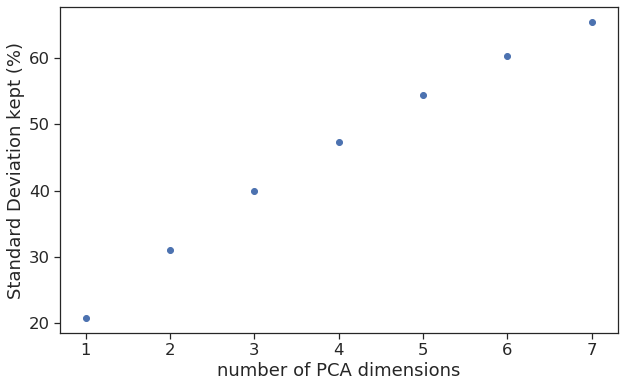

In [97]:
fig = plt.figure(figsize=(10,6))
plt.scatter(np.arange(1,8), 100*pca.explained_variance_ratio_.cumsum())
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('number of PCA dimensions')
ax.set_ylabel('Standard Deviation kept (%)')

#### We now know that we need about 3 or 4 elements in PCA to keep the standard deviation.

## PCA with 2 components

In [98]:
pca = PCA(n_components = 2)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True),
                     pd.DataFrame(scores_pca, 
                     columns = ['Component 1', 'Component 2'])], axis = 1)

In [99]:
df_comp

vars.CPU_time_s  vars.elapsed_time  vars.final_iteration  \
0       1.500000e+07           41677.42             2084205.0   
1       3.868000e+02              16.12                7854.0   
2       4.656000e+07           41567.26                   0.0   
3       8.508000e+04             157.55                 100.0   
4       6.549000e+02             327.47                5039.0   
5       1.462000e+07           40618.48              476200.0   
6       1.500000e+07           41653.58             6163793.0   
7       8.827000e+03             882.69               22654.0   
8       1.500000e+07           41659.04             7790840.0   
9       2.620000e+04             363.92               12192.0   
10      1.379000e+05             574.59               23831.0   
11      1.844000e+07           34139.35              244000.0   
12      1.356000e+04             565.16             1325258.0   
13      1.551000e+06            6462.64              278940.0   
14      4.762000e+07           42518.08                   0.0   
15      1.524000e+07           28225.89              205100.0   
16      0.000000e+00               2.00             1323142.0   
17      1.173000e+03              32.58              373593.0   
18      1.500000e+07           41678.58             2274910.0   
19      0.000000e+00               1.00             1323142.0   
20      1.500000e+07           41659.72             4273447.0   
21      1.173000e+03              32.58              373593.0   
22      8.166000e+06           22684.37             2065356.0   
23      8.827000e+03             882.69               22654.0   
24      5.612000e-01               0.56                   1.0   
25      1.428000e+06            5948.74              259524.0   
26      4.508000e+02              12.52              102383.0   
27      9.538000e+02              26.49              102388.0   
28      1.103000e+06            4597.57              201934.0   
29      1.313000e+03              18.23                 500.0   
..               ...                ...                   ...   
146     2.194000e+07           40636.31              402078.0   
147     1.512000e+07           42012.64              947391.0   
148     2.253000e+07           41715.29              437838.0   
149     1.501000e+07           41689.21              925739.0   
150     8.026000e+03             334.44             1970367.0   
151     1.918000e+03              53.28              306600.0   
152     4.086000e+07           36485.93              836302.0   
153     1.391000e+06            5797.35              150785.0   
154     1.627000e+04             452.08              793324.0   
155     8.742000e+04            1214.17               10221.0   
156     1.500000e+07           41676.73              376268.0   
157     1.512000e+07           42011.58             1264213.0   
158     1.918000e+03              53.28              306600.0   
159     2.172000e+01               0.90                  10.0   
160     9.489000e+02              26.36              102380.0   
161     1.512000e+07           42013.12             2246624.0   
162     8.827000e+03             882.69               22654.0   
163     8.742000e+04            1214.17               10221.0   
164     4.814000e+07           42978.72              776302.0   
165     1.501000e+07           41681.85             2304296.0   
166     2.697000e+04            1123.79             3150300.0   
167     1.173000e+03              32.58              373593.0   
168     3.258000e+01               0.90                 188.0   
169     4.754000e+03             132.05             1494404.0   
170     1.211000e+06            5046.45              239555.0   
171     0.000000e+00               0.00                   0.0   
172     3.482000e+05            1450.76               60125.0   
173     0.000000e+00               0.00                   0.0   
174     4.508000e+02              12.52              102383.0   
175     7.639000e+05            3182.78 

In [100]:
df_pca.columns

Index(['vars.CPU_time_s', 'vars.elapsed_time', 'vars.final_iteration',
       'vars.initial_iteration', 'vars.initial_time', 'vars.physical_time',
       'vars.time_per_ite', 'params.ncell_group', 'vars.MPI_processes',
       'parmetis', 'User 1', 'User 2', 'User 3', 'User 4', 'User 5',
       'date_hour', 'date_year', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednedsday'],
      dtype='object')

In [101]:
df_pcacomponents = pd.DataFrame(abs(pca.components_), columns = df_pca.columns)
df_pcacomponents

vars.CPU_time_s  vars.elapsed_time  vars.final_iteration  \
0         0.349740           0.410323              0.330008   
1         0.289218           0.079529              0.267039   

   vars.initial_iteration  vars.initial_time  vars.physical_time  \
0                0.352032           0.100440            0.048507   
1                0.145671           0.300245            0.262063   

   vars.time_per_ite  params.ncell_group  vars.MPI_processes      parmetis  \
0           0.234610            0.155369            0.286490  0.000000e+00   
1           0.281968            0.003065            0.415296  8.673617e-19   

   ...    User 5  date_hour  date_year    Friday    Monday  Saturday  \
0  ...  0.159263    0.15567   0.178308  0.010338  0.021446  0.099345   
1  ...  0.113361    0.07858   0.122844  0.165815  0.029134  0.028389   

     Sunday  Thursday   Tuesday  Wednedsday  
0  0.072746  0.040354  0.007966    0.017837  
1  0.022345  0.143928  0.093677    0.323996  

[2 rows x 24 columns]

Text(106.5, 0.5, "['PCA Componant 1', 'PCA Componant 2']")

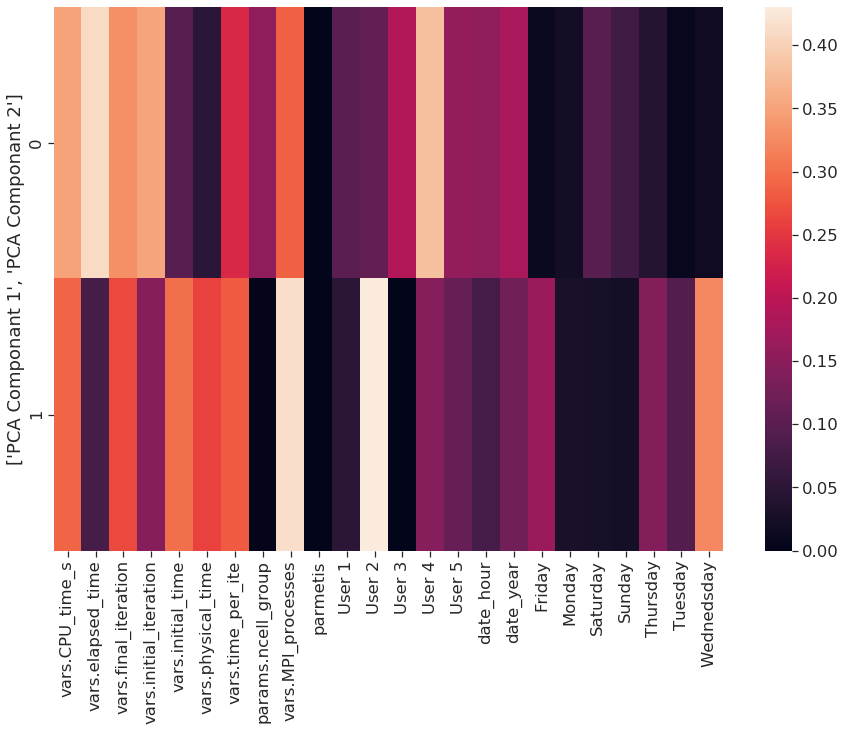

In [102]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1)
sns.heatmap(df_pcacomponents)
ax.set_ylabel(['PCA Componant 1', 'PCA Componant 2'])

In [103]:
np.transpose(pca.components_)

array([[ 3.49739617e-01, -2.89217999e-01],
       [ 4.10322781e-01, -7.95286996e-02],
       [ 3.30007703e-01,  2.67039310e-01],
       [ 3.52031980e-01,  1.45671247e-01],
       [ 1.00440480e-01,  3.00245192e-01],
       [ 4.85072106e-02,  2.62063375e-01],
       [ 2.34610344e-01,  2.81967510e-01],
       [ 1.55368732e-01, -3.06501160e-03],
       [ 2.86490094e-01, -4.15296099e-01],
       [-0.00000000e+00, -8.67361738e-19],
       [-1.01852234e-01, -4.90785649e-02],
       [ 1.10603631e-01, -4.30286884e-01],
       [-1.89257939e-01,  7.08889208e-04],
       [ 3.81092076e-01,  1.44578000e-01],
       [-1.59262716e-01,  1.13361317e-01],
       [-1.55669925e-01,  7.85804660e-02],
       [-1.78307970e-01, -1.22844194e-01],
       [-1.03376250e-02,  1.65815119e-01],
       [-2.14458799e-02, -2.91337376e-02],
       [ 9.93453647e-02,  2.83887788e-02],
       [ 7.27455825e-02, -2.23452175e-02],
       [-4.03543747e-02,  1.43928085e-01],
       [ 7.96633448e-03,  9.36769445e-02],
       [-1.

In [104]:
df_pca.columns[0]

'vars.CPU_time_s'

In [105]:
def biplot(scores_pca, coeff):
    
    x = scores_pca[:,0] # projection on PC1
    print(x)
    y = scores_pca[:,1] # projection on PC2
    print(y)
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,0]*1.01, coeff[i,1]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PCA Component{}".format(1), size=14)
    plt.ylabel("PCA Component{}".format(2), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.4,0.4])
    plt.ylim([-0.4,0.4])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

[ 3.34032035 -1.32518661  3.77490792 -0.5187905  -1.64181678  2.43804081
  4.74413584 -1.58255167  5.67684254 -1.56202006 -1.48015953  0.72709762
 -1.25572569 -1.28340815  3.30067958  0.54329971 -0.01794201 -1.42050403
  2.85313694 -0.55542707  3.45364846 -1.42050403  2.26892681 -1.41081574
 -1.81834259 -1.51367378 -1.78591953 -1.69968449 -0.9867331  -1.39007977
 -2.08781251  2.57090001 -1.42884015  3.20350906 -1.37650418 -2.25965537
  4.53781783 -1.96570806  2.39306887  4.88332172  1.72601581 -1.70011363
 -1.29635458 -0.86480819  0.28386642 -1.42190653 -1.50625742 -1.3264424
 -1.79452034 -2.20832928 -1.26383294 -1.4740599   4.81416337 -1.76671543
 -1.54307469 -1.20877847  0.26488029 -1.19372134 -1.28651512  4.89062038
 -1.42491288 -0.00680479 -1.72008875 -1.66035959  2.46775878 -1.42050403
 -1.70177544 -1.52397407  2.97985004  2.49508824 -1.32905023  0.3674823
 -0.76758136 -1.78549837  1.1191407  -1.54923323 -1.31496175 -1.69967899
  0.55360443 -1.62709304  1.07176626  1.99310591 -1.4

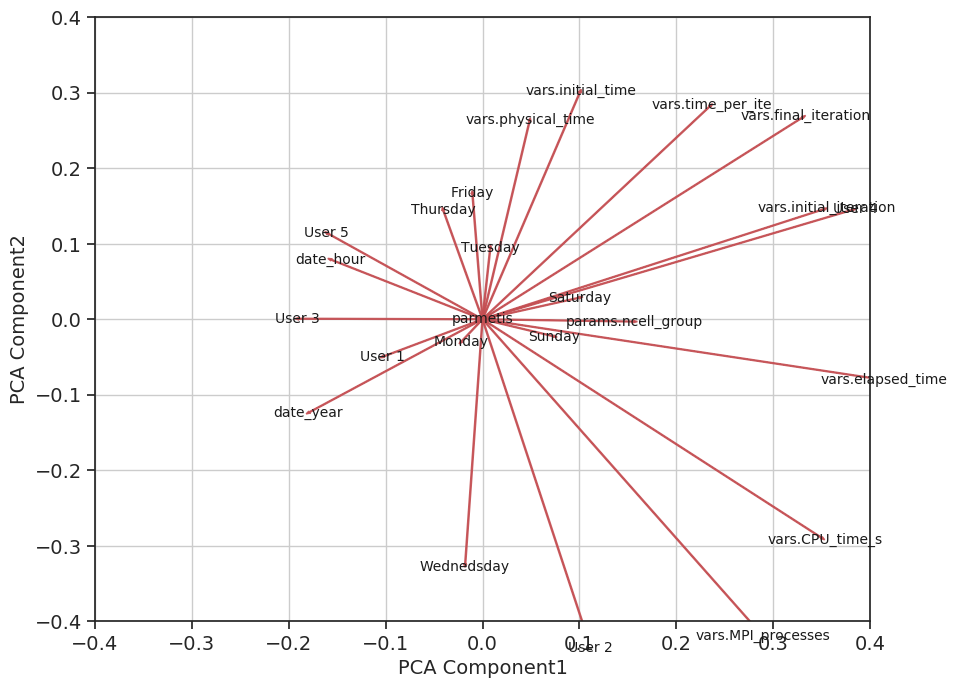

In [106]:
biplot(scores_pca, np.transpose(pca.components_))
plt.show()

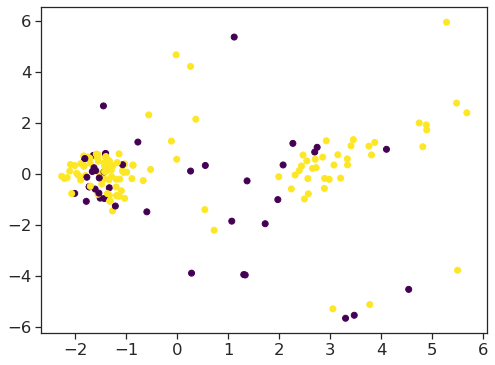

In [107]:
fig = plt.figure(figsize = (8,6))

plt.scatter(scores_pca[:,0], scores_pca[:,1], 
            c = df_pca_c['converged'], cmap = 'viridis')

## Determination du nombre de clusters optimal

In [108]:
from sklearn.cluster import KMeans

In [109]:
# on ne connait pas au préalable le nombre de clusters dans les runs
#on va maintenant montrer que le nombre de cluster optimal est bien 3
# Inertia is the sum of squared distances of samples to their closest cluster centre avec la donnée kmeans.inertia_

distance = []
for i in range(1,6):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scores_pca)
    distance.append(kmeans.inertia_)

Text(0, 0.5, 'kmeans distance')

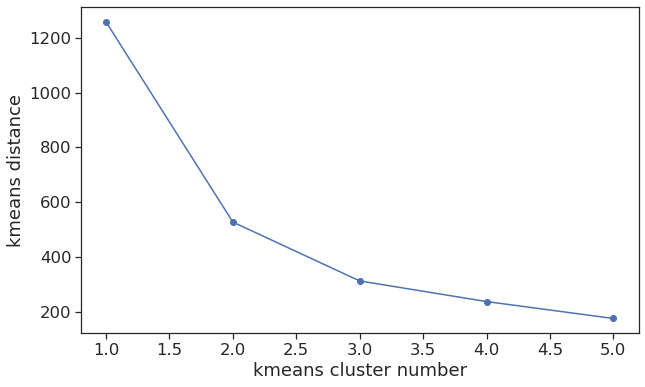

In [110]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(1,1, 1)
plt.plot(range(1,6), distance, '-o')
ax.set_xlabel('kmeans cluster number')
ax.set_ylabel('kmeans distance')

We see that above 3 clusters in the kmeans model doesn't make the distance drop so much, so 3 is the optimal value.
We can deduce here that we have 3 big tendencies in our runs.

## Kmeans with 3 clusters 

In [111]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

[0 1 2 1 1 0 0 1 0 1 1 2 1 1 2 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 2
 1 0 0 2 1 1 1 2 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1
 0 1 1 1 1 1 2 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1 2 0 0 2 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 2 0 0
 0 0 1 1 2 1 1 1 0 0 1 1 1 0 1 1 2 0 1 1 1 1 1 1 1 1 1 1]


In [112]:
kmeans.cluster_centers_.shape

(3, 2)

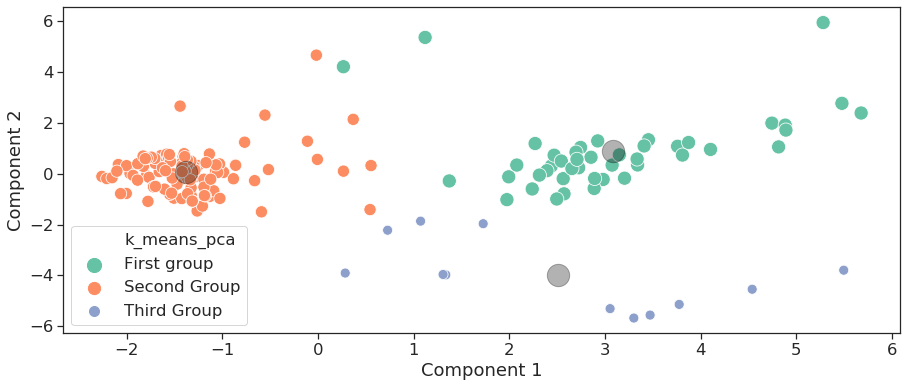

In [113]:
#ax = sns.scatterplot(x="total_bill", y="tip",
#                     hue="size", size="size",
##                     sizes=(20, 200), hue_norm=(0, 7),
#                     legend="full", data=tips)
# With 2 components in PCA and kmeans = 4
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (15,6))
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (100,200), palette="Set2")
#sns.scatterplot(x, y, hue = df_pca_c['converged'], 
#                palette="Set1", alpha = 0.4)
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 500, c='black', label = 'Centroids', alpha = 0.3)

In [114]:
df_process_mean = df_comp.groupby('k_means_pca').mean()
df_process_mean

vars.CPU_time_s  vars.elapsed_time  vars.final_iteration  \
k_means_pca                                                              
First group      1.414931e+07       37422.729773          2.695008e+06   
Second Group     3.947231e+05        1504.177667          2.754872e+05   
Third Group      3.178083e+07       29945.490000          8.498719e+05   

              vars.initial_iteration  vars.initial_time  vars.physical_time  \
k_means_pca                                                                   
First group             2.475303e+06           0.237569            0.242718   
Second Group            9.309730e+04           0.069012            0.096679   
Third Group             1.491785e+06           0.089602            0.049037   

              vars.time_per_ite  params.ncell_group  vars.MPI_processes  \
k_means_pca                                                               
First group            0.834161           76.818182          352.727273   
Second Group           0.101382           54.166667          112.666667   
Third Group            0.189167           81.666667         1065.000000   

              parmetis  ...    date_year    Friday    Monday  Saturday  \
k_means_pca             ...                                              
First group        1.0  ...  2018.500000  0.090909  0.113636  0.136364   
Second Group       1.0  ...  2019.041667  0.108333  0.133333  0.025000   
Third Group        1.0  ...  2019.250000  0.000000  0.166667  0.000000   

                Sunday  Thursday   Tuesday  Wednedsday  Component 1  \
k_means_pca                                                           
First group   0.045455  0.204545  0.318182    0.090909     3.077787   
Second Group  0.000000  0.241667  0.225000    0.266667    -1.379208   
Third Group   0.083333  0.000000  0.000000    0.750000     2.506860   

              Component 2  
k_means_pca                
First group      0.870616  
Second Group     0.080118  
Third Group     -3.993443  

[3 rows x 26 columns]

In [115]:
df_process_std = df_comp.groupby('k_means_pca').std()

In [116]:
dataframe = pd.concat([df_comp[df_comp['k_means_pca'] == 'First group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'First group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Second Group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group']
#dataframe.sort_values(by ='Mean Third group', ascending = False)

In [117]:
dataframe

Mean First group  Std First Group  Mean Second group  \
vars.CPU_time_s             1.414931e+07     5.134736e+06      394723.134707   
vars.elapsed_time           3.742273e+04     1.230309e+04        1504.177667   
vars.final_iteration        2.695008e+06     2.357163e+06      275487.191667   
vars.initial_iteration      2.475303e+06     2.374297e+06       93097.300000   
vars.initial_time           2.375693e-01     4.188939e-01           0.069012   
vars.physical_time          2.427182e-01     4.182448e-01           0.096679   
vars.time_per_ite           8.341614e-01     7.606420e-01           0.101382   
params.ncell_group          7.681818e+01     2.955269e+01          54.166667   
vars.MPI_processes          3.527273e+02     1.065939e+02         112.666667   
parmetis                    1.000000e+00     0.000000e+00           1.000000   
User 1                      0.000000e+00     0.000000e+00           0.183333   
User 2                      0.000000e+00     0.000000e+00           0.008333   
User 3                      2.272727e-02     1.507557e-01           0.458333   
User 4                      9.545455e-01     2.107071e-01           0.016667   
User 5                      2.272727e-02     1.507557e-01           0.333333   
date_hour                   1.106818e+01     6.912738e+00          14.566667   
date_year                   2.018500e+03     5.498414e-01        2019.041667   
Friday                      9.090909e-02     2.908034e-01           0.108333   
Monday                      1.136364e-01     3.210382e-01           0.133333   
Saturday                    1.363636e-01     3.471418e-01           0.025000   
Sunday                      4.545455e-02     2.107071e-01           0.000000   
Thursday                    2.045455e-01     4.080325e-01           0.241667   
Tuesday                     3.181818e-01     4.711553e-01           0.225000   
Wednedsday                  9.090909e-02     2.908034e-01           0.266667   
Component 1                 3.077787e+00     1.141507e+00          -1.379208   
Component 2                 8.706160e-01     1.457859e+00           0.080118   

                        Std Second Group  Mean Third group  Std Third Group  
vars.CPU_time_s             1.480079e+06      3.178083e+07     2.289795e+07  
vars.elapsed_time           3.395769e+03      2.994549e+04     1.824719e+04  
vars.final_iteration        6.536188e+05      8.498719e+05     1.036402e+06  
vars.initial_iteration      4.817140e+05      1.491785e+06     1.197739e+06  
vars.initial_time           3.101695e-01      8.960240e-02     8.546401e-02  
vars.physical_time          5.872989e-01      4.903745e-02     8.106231e-02  
vars.time_per_ite           2.853979e-01      1.891667e-01     2.054140e-01  
params.ncell_group          3.892642e+01      8.166667e+01     2.757909e+01  
vars.MPI_processes          1.381525e+02      1.065000e+03     2.727803e+02  
parmetis                    0.000000e+00      1.000000e+00     0.000000e+00  
User 1                      3.885620e-01      8.333333e-02     2.886751e-01  
User 2                      9.128709e-02      6.666667e-01     4.923660e-01  
User 3                      5.003500e-01      1.666667e-01     3.892495e-01  
User 4                      1.285559e-01      8.333333e-02     2.886751e-01  
User 5                      4.733811e-01      0.000000e+00     0.000000e+00  
date_hour                   4.579335e+00      1.158333e+01     4.420167e+00  
date_year                   6.135149e-01      2.019250e+03     6.215816e-01  
Friday                      3.121041e-01      0.000000e+00     0.000000e+00  
Monday                      3.413599e-01      1.666667e-01     3.892495e-01  
Saturday                    1.567796e-01      0.000000e+00     0.000000e+00  
Sunday                      0.000000e+00      8.333333e-02     2.886751e-01  
Thursday                    4.298883e-01      0.000000e+00     0.000000e+00  
Tuesday                     4.193332e-01      0.000000e+00     0.0000

In [118]:
dataframe = dataframe.drop(index = ['Component 1', 'Component 2'], axis = 0)

Features that have a mean value and standard deviation of 0 are not describing at all the group=

In [119]:
not_first_group = dataframe[(dataframe['Mean First group'] == 0) & (dataframe['Std First Group'] ==0.0)].index
not_second_group = dataframe[(dataframe['Mean Second group'] == 0) & (dataframe['Std Second Group'] ==0.0)].index
not_third_group = dataframe[(dataframe['Mean Third group'] == 0) & (dataframe['Std Third Group'] ==0.0)].index

In [120]:
dataframe.iloc[8]

Mean First group      352.727273
Std First Group       106.593853
Mean Second group     112.666667
Std Second Group      138.152475
Mean Third group     1065.000000
Std Third Group       272.780298
Name: vars.MPI_processes, dtype: float64

Repartition des standard deviations en fonction des groupes

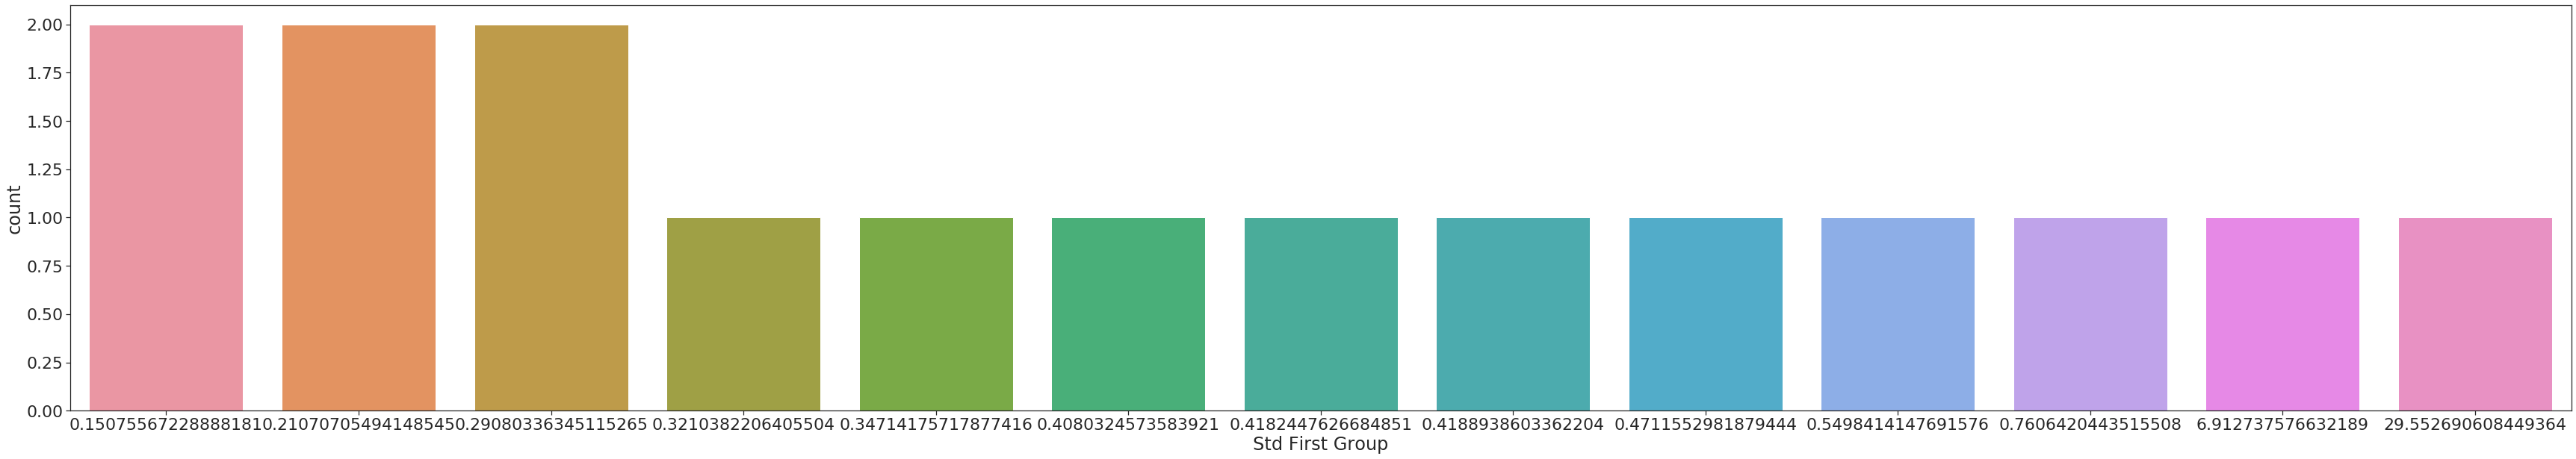

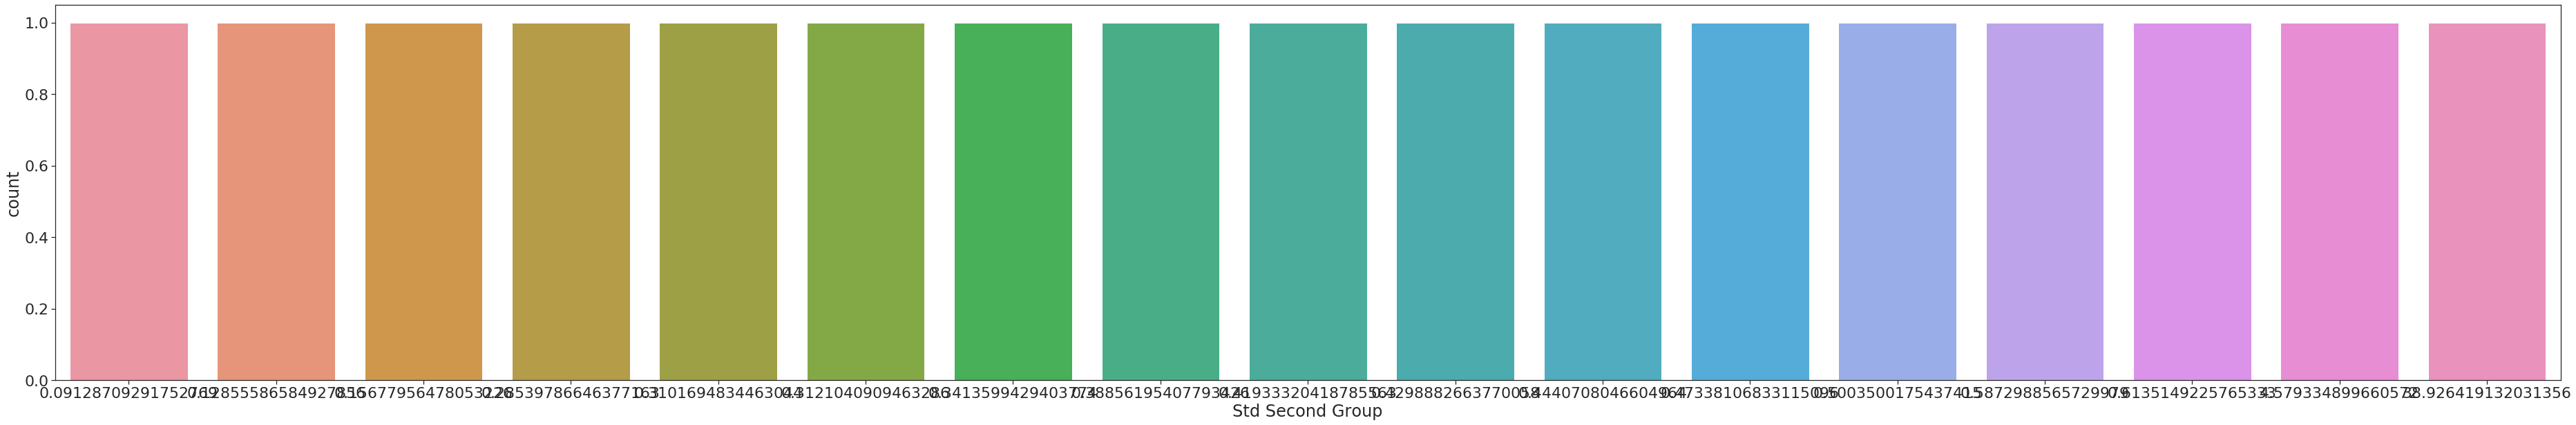

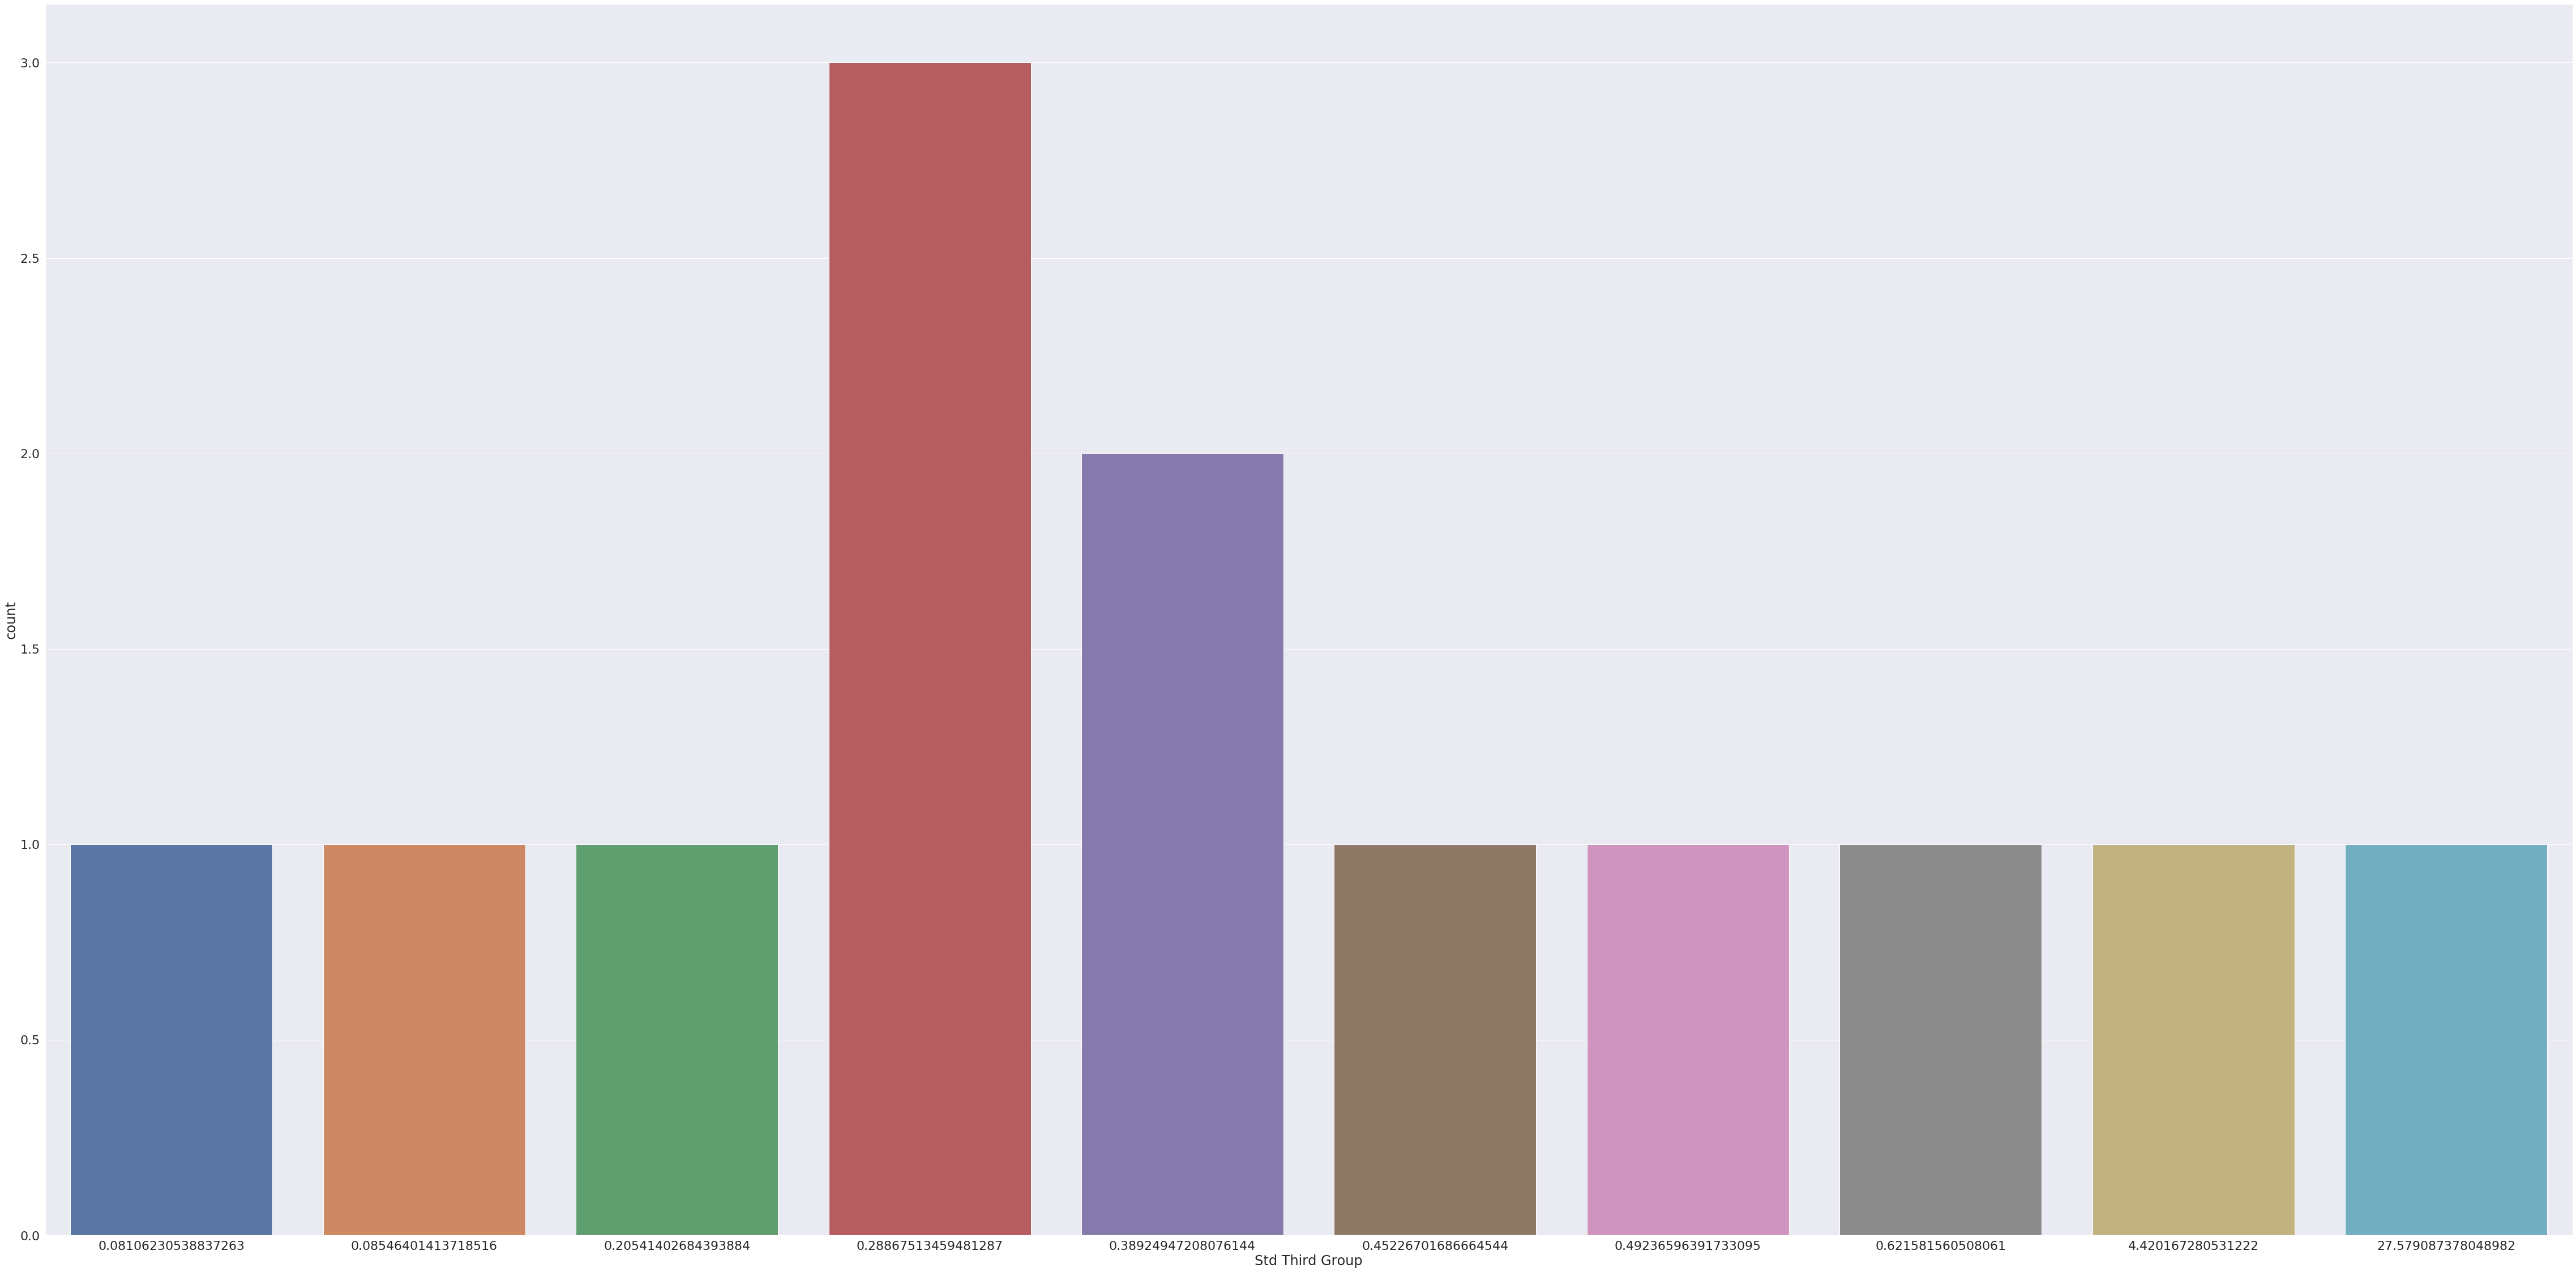

In [121]:
sns.set(font_scale=2)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig = plt.figure(figsize = (60,10))
ax = fig.add_subplot(1,1, 1)
#sns.countplot()
sns.countplot(dataframe[dataframe['Std First Group']>0]['Std First Group'].drop(
    index = ['vars.CPU_time_s', 'vars.initial_iteration', 'vars.final_iteration', 'vars.elapsed_time',
             'vars.MPI_processes']))
fig = plt.figure(figsize = (65,10))
ax = fig.add_subplot(1,1, 1)
sns.countplot(dataframe[dataframe['Std Second Group']>0]['Std Second Group'].drop(
    index = ['vars.CPU_time_s', 'vars.initial_iteration', 'vars.final_iteration', 'vars.elapsed_time',
            'vars.MPI_processes']))
sns.set(font_scale=2)
fig = plt.figure(figsize = (80,40))
ax = fig.add_subplot(1,1, 1)
sns.countplot(dataframe[dataframe['Std Third Group']>0]['Std Third Group'].drop(
    index = ['vars.CPU_time_s', 'vars.initial_iteration', 'vars.final_iteration', 'vars.elapsed_time',
            'vars.MPI_processes']))


KeyError: "['vars.mesh_cells'] not found in axis"

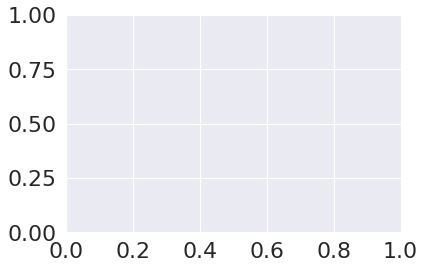

In [122]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
dataframe[dataframe['Std Third Group']>0]['Std Third Group'].drop(index = 'vars.mesh_cells').plot.hist()
ax.set_xlabel('std')
ax.set_ylabel('nb of features')

#ax = fig.add_subplot(1, 1, 1)
#dataframe['Std Second Group'].drop(index = 'vars.mesh_cells').plot.hist()

#ax = fig.add_subplot(1, 1, 1)
#dataframe['Std First Group'].drop(index = 'vars.mesh_cells').plot.hist()
#plt.legend()

Features with non null mean value and null standard deviation describe exactly the groups:

In [123]:
in_first_group = dataframe[(dataframe['Mean First group'] != 0) & (dataframe['Std First Group'] ==0.0)].index

in_second_group = dataframe[(dataframe['Mean Second group'] != 0) & (dataframe['Std Second Group'] ==0.0)].index

in_third_group = dataframe[(dataframe['Mean Third group'] != 0) & (dataframe['Std Third Group'] ==0.0)].index

In [124]:
in_second_group

Index(['parmetis'], dtype='object')

Features with non null mean value and low standard deviation describe features that can be describing the groups:

In [125]:
often_in_first_group = dataframe[(dataframe['Mean First group'] != 0) & (dataframe['Std First Group'] < 0.2)].index

often_in_second_group = dataframe[(dataframe['Mean Second group'] != 0) & (dataframe['Std Second Group'] < 0.2)].index

often_in_third_group = dataframe[(dataframe['Mean Third group'] != 0) & (dataframe['Std Third Group'] < 0.2)].index

In [126]:
in_first_group
in_second_group
in_third_group


Index(['parmetis'], dtype='object')

In [127]:
for i in in_first_group:
    print('Run first group always is', i)

for i in in_second_group:
    print('Run second group always is', i)
  
for i in in_third_group:
    print('Run third group always is', i)

  


Run first group always is parmetis
Run second group always is parmetis
Run third group always is parmetis


In [128]:
for feature in dataframe.index:
    #print(feature)
    if feature not in not_first_group:
        pass
        #print('Third group can be', feature)
    else:
        print('First group is never', feature)
print('')
for i in in_first_group:
    print('First group is always ', i)
print('')  
for i in often_in_first_group:
    print('First group is often ', i)
print('') 

for feature in dataframe.index:
    #print(feature)
    if feature not in not_second_group:
        pass
    else:
        print('Second group is never', feature)
print('')
for i in in_second_group:
    print('Second group is always', i)
print('')
for i in often_in_second_group:
    print('Second group is often ', i)
print('') 

for feature in dataframe.index:
    #print(feature)
    if feature not in not_third_group:
        pass
        #print('Third group can be', feature)
    else:
        print('Third group is never', feature)
        
for i in in_third_group:
    print('Third group is always', i)
print('')
for i in often_in_third_group:
    print('Third group is often ', i)
print('') 


First group is never User 1
First group is never User 2

First group is always  parmetis

First group is often  parmetis
First group is often  User 3
First group is often  User 5

Second group is never Sunday

Second group is always parmetis

Second group is often  parmetis
Second group is often  User 2
Second group is often  User 4
Second group is often  Saturday

Third group is never User 5
Third group is never Friday
Third group is never Saturday
Third group is never Thursday
Third group is never Tuesday
Third group is always parmetis

Third group is often  vars.initial_time
Third group is often  vars.physical_time
Third group is often  parmetis



In [ ]:
print(len(not_third_group))

Typing function
- we want to create a classifying function that is looking at the mean value for each feature and the standard deviation.
if std is 0 and mean is 0, the run is definitely not in the group of the feature
if std is (stddev=0, mean=1)  Ces runs  sont toujours :  Wale, ...
(Et ci tu penses que ca a du sens:
-(stddev< threshold, mean<threshold) Ces runs sont rarement :  ...
-(stddev<threshold, mean>threshold)  Ces runs  sont souvent :  ...

In [ ]:
dataframe = pd.concat([df_comp2[df_comp2['k_means_pca'] == 'First group'].std(), 
             df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std(), 
             df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['First group', 'Second group', 'Third group']
dataframe

In [ ]:
df_comp2[df_comp2['k_means_pca'] == 'Second Group'].mean()
df_comp2[df_comp2['k_means_pca'] == 'Second Group'].std()

In [ ]:
df_comp2[df_comp2['k_means_pca'] == 'Third Group'].mean()
df_comp2[df_comp2['k_means_pca'] == 'Third Group'].std()


In [ ]:
df_comp2.groupby('k_means_pca').mean()

In [ ]:
df_comp2.groupby('k_means_pca').std()

In [ ]:
df_comp2.head()

The PCA gives us a hint of how to plot in 2D the plots.
so we know that we can plot runs by colin_species and wale, maybe vars.dimension and ncell group.
so we can also make a pairplot regarding these variables.

## Kmeans with 3 clusters with highlight of converged/not converged

In [ ]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

In [ ]:
# With 2 components in PCA and kmeans = 4
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (15,10))
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
                palette = ['g', 'r', 'b'], alpha = 0.6)

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'],
                sizes= (600,700), palette="Set2")

sns.scatterplot(x, y, hue = df_pca_c['converged'], 
                size = df_pca_c['converged'],
               sizes = (200,200), palette = ['r', 'g'])

plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 1000, c='yellow', label = 'Centroids', alpha = 0.3)


## PCA with 4 components

We know that a PCA with 4 components should optimize the standard deviation kept in the dimension reduction.

In [ ]:
## PCA with 4 components
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data
pca = PCA(n_components = 4)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_comp.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']

scores_pca stores the projections of each run in the new frame system.
PCA_components stores the linear coefficients of each PCA component of the original features.

In [ ]:
pca4 = pd.DataFrame(abs(pca.components_), columns = df_pca.columns)
pca4['PCA components'] = [0, 1, 2, 3]
pca4.set_index('PCA components')
pca4['KERO_LUCHE']

In [ ]:
scores_pca

for the first component of PCA, we can see that the most important features are params.ncell_group, params.smu2, vars.MPI_processes, vars.dimension, vars.nodes and AIR.

In [ ]:
def biplot4(scores_pca, coeff):
    
    x = scores_pca[:,0] # projection on PC1
    print(x)
    y = scores_pca[:,1] # projection on PC2
    print(y)
    
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,0], coeff[i,1], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,0]*1.01, coeff[i,1]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

In [ ]:
biplot4(scores_pca, np.transpose(pca.components_))
plt.show()

In [ ]:
def biplot4(scores_pca, coeff):
    
    x = scores_pca[:,2] # projection on PC1
    print(x)
    y = scores_pca[:,3] # projection on PC2
    print(y)
    
    
    n = coeff.shape[0] # number of variables
    print(n)
    plt.figure(figsize=(10,8), dpi=100)

    colors = ['g','r','y']
    markers=['o','^','x']

    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0.0, 0.0, coeff[i,2], coeff[i,3], color = 'r', alpha = 0.9,
                  linestyle = '-',linewidth = 1.1, overhang=0.2)
        plt.text(coeff[i,2]*1.01, coeff[i,3]*1.01, df_pca.columns[i], 
                 color = 'k', ha = 'center', va = 'center',fontsize=10)
        
    plt.xlabel("PC{}".format(3), size=14)
    plt.ylabel("PC{}".format(4), size=14)
#    limx= int(x.max())
#    limy= int(y.max())
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.5,0.5])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

In [ ]:
biplot4(scores_pca, np.transpose(pca.components_))
plt.show()

In [ ]:
df_comp.head()

In [ ]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

In [ ]:
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group'})
fig = plt.figure(figsize = (25,20))
ax1 = fig.add_subplot(2,2,1)
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax2 = fig.add_subplot(2,2,2)
x = df_comp['Component 1']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax3 = fig.add_subplot(2,2,3)
x = df_comp['Component 1']
y = df_comp['Component 4']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

ax4 = fig.add_subplot(2,2,4)
x = df_comp['Component 2']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

In [ ]:
fig = plt.figure(figsize = (10,6))
x = df_comp['Component 1']
y = df_comp['Component 4']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

In [ ]:
df_comp3 = df_comp.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2', 'Component 3', 'Component 4'], axis = 1)
df_comp3.groupby('k_means_pca').mean()

In [ ]:
df_comp3.groupby('k_means_pca').std()

In [ ]:
dataframe = pd.concat([df_comp3[df_comp3['k_means_pca'] == 'First group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'First group'].std(),
                       df_comp3[df_comp3['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'Second Group'].std(),
                       df_comp3[df_comp3['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp3[df_comp3['k_means_pca'] == 'Third Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group']
dataframe.sort_values(by ='Mean Second group', ascending = False)


# Kmeans = 4

In [ ]:
## PCA with 4 components
scaler = StandardScaler()
scaler.fit(df_pca)
scaled_data = scaler.transform(df_pca)
scaled_data
pca = PCA(n_components = 4)
pca.fit(scaled_data)
scores_pca = pca.transform(scaled_data)
#scores_pca
df_comp = pd.concat([df_pca.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_comp.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
kmeans = KMeans(n_clusters = 4)
kmeans.fit(scores_pca)
df_comp['k_means_pca'] = kmeans.labels_
print(kmeans.labels_)

In [ ]:
# Now ce can visualize our data on two components from the PCA, colored by Kmeans
df_comp['k_means_pca'] = df_comp['k_means_pca'].map({0: 'First group', 
                                                     1: 'Second Group',
                                                    2: 'Third Group', 
                                                     3: 'Fourth Group'})

fig = plt.figure(figsize = (25,20))
ax1 = fig.add_subplot(2,2,1)
x = df_comp['Component 1']
y = df_comp['Component 2']

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
#sns.scatterplot( x, y, hue = df_comp['k_means_pca'], 
#                palette = ['g', 'r', 'b'])

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax2 = fig.add_subplot(2,2,2)
x = df_comp['Component 1']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'],
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax3 = fig.add_subplot(2,2,3)
x = df_comp['Component 1']
y = df_comp['Component 4']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], 
                size = df_comp['k_means_pca'], sizes= (200,200),
                 palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

ax4 = fig.add_subplot(2,2,4)
x = df_comp['Component 2']
y = df_comp['Component 3']

sns.scatterplot(x, y, hue = df_comp['k_means_pca'], size = df_comp['k_means_pca'],
                sizes= (200,200), palette="Set2")
plt.scatter(kmeans.cluster_centers_[0, 0], 
            kmeans.cluster_centers_[0, 1],  
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[1, 0], 
            kmeans.cluster_centers_[1, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[2, 0], 
            kmeans.cluster_centers_[2, 1], 
            s= 300, c='grey', label = 'Centroids')

plt.scatter(kmeans.cluster_centers_[3, 0], 
            kmeans.cluster_centers_[3, 1], 
            s= 300, c='grey', label = 'Centroids')

In [ ]:
df_comp = df_comp.drop(['params.reactive_flow','params.real_gas', 
                                            'params.two_phase_flow', 'Component 1', 
                                            'Component 2', 'Component 3', 'Component 4'], axis = 1)
df_comp.groupby('k_means_pca').mean()

In [ ]:
dataframe = pd.concat([df_comp[df_comp['k_means_pca'] == 'First group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'First group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Second Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Second Group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Third Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Third Group'].std(),
                       df_comp[df_comp['k_means_pca'] == 'Fourth Group'].mean(), 
                       df_comp[df_comp['k_means_pca'] == 'Fourth Group'].std()], axis = 1) 
dataframe.columns =  ['Mean First group', 'Std First Group', 
                      'Mean Second group', 'Std Second Group',
                      'Mean Third group', 'Std Third Group',
                     'Mean Fourth group', 'Mean Fourth Group']
dataframe.sort_values(by ='Mean Third group', ascending = False)